# LikeWise

### A Comparison of Book Recommender Systems

### By _Owen Burton_ and _Tobias Reaper_

---
---

## Outline

* [Introduction]()
* [_Imports and Configuration_]()
* [Data]()
  * [Loading and Looking]()
  * [Wrangling and Exploration]()

---
---

## Introduction

### Stop! Collaborate and Filter

[Collaborative Filtering](https://d2l.ai/chapter_recommender-systems/recsys-intro.html#collaborative-filtering) (CF)

> In general, CF only uses the user-item interaction data to make predictions and recommendations.

---
---

## Imports and Configuration

In [1]:
# === General imports === #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

In [2]:
# === fastai imports === #
from fastai.collab import *

In [3]:
# === Configuration === #
%matplotlib inline
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# === Set up path to project dir === #
PROJECT_DIR = "/content/drive/My Drive/workshop/buildbox/likewise"

---
---

## Data

Intro to and explanation of dataset — why this dataset?

Here is the dataset used for the LikeWise recommender systems: [UCSD Book Graph - GoodReads Datasets](https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home).

For this particular model, I'll be using the "Shelves" dataset, which has interactions between users and books (ratings).

The relevant columns are `user_id`, `book_id`, and `rating`. They are pretty self-explanatory, but just to be explicit, each record indicates a user rating a book that they've (presumably) read and have an opinion on.

Speaking of explicit, the fact that the user _explicitly_ rates the books makes this dataset one of explicit preferences

---

### Load and Look

Load the dataset and look at basic descriptive statistics.

#### Download

To develop and validate the initial models, we'll be using a genre-wise subset of the full interactions dataset for the Mystery, Thriller & Crime genre. This subset contains ~24.8m interactions (1.33 GB), as opposed to the ~229m (4.1 GB?) of the full dataset.

The datasets can be [downloaded](https://github.com/MengtingWan/goodreads/blob/master/download.ipynb) from the creator's Google Drive using the `gdown` package.

The "Shelves" dataset, including the genre-wise subsets, do not include the title of the book. It will be useful to get those titles matched up with their respective IDs at some point.

In [2]:
# === Download goodreads_interactions_mystery_thriller_crime.json.gz === #
import gdown

file_id = "1xuujDT-vOMMkk2Kog0CTT9ADmnD8pa9D"
url = "https://drive.google.com/uc?id=" + file_id
gdown.download(url, output=None, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1xuujDT-vOMMkk2Kog0CTT9ADmnD8pa9D
To: /content/goodreads_interactions_mystery_thriller_crime.json.gz
1.33GB [00:22, 58.5MB/s]


'goodreads_interactions_mystery_thriller_crime.json.gz'

In [3]:
# === Download book_id_map.csv to get titles === #
file_id = "1CHTAaNwyzvbi1TR08MJrJ03BxA266Yxr"
url = "https://drive.google.com/uc?id=" + file_id
gdown.download(url, output=None, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1CHTAaNwyzvbi1TR08MJrJ03BxA266Yxr
To: /content/book_id_map.csv
37.8MB [00:01, 31.1MB/s]


'book_id_map.csv'

In [9]:
# === Copy book_id_map.csv to assets dir === #
!rsync -ah --info=progress2 book_id_map.csv "/content/drive/My Drive/workshop/buildbox/likewise/assets/data"

         37.85M 100%  165.42MB/s    0:00:00 (xfr#1, to-chk=0/1)


#### Load interactions sample

According to the UCSD Book Graph site, the Mystery, Thriller & Crime subset contains `24,799,896` interactions. This is too large to fit into the free Colab memory (where I initially developed the first models). Thus, I'll take a sample of `1,000,000` records.

In [6]:
# === First, load from gzipped json === #
import gzip
import json
from typing import List

def load_data(file_name: str, num_items: int) -> List[dict]:
    """Output a list of user-book interactions"""
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)
            
            if (num_items is not None) and (count == num_items):
                break
    return data

# === Load sample of ___ records === #
interactions_raw = load_data(
    "/content/goodreads_interactions_mystery_thriller_crime.json.gz",
    num_items=1000000
)

assert len(interactions_raw) == 1000000

In [7]:
# === Take a look at one of the records === #
interactions_raw[-1]

{'book_id': '17266736',
 'date_added': 'Sun Feb 24 13:51:33 -0800 2013',
 'date_updated': 'Sat Mar 23 14:27:27 -0700 2013',
 'is_read': True,
 'rating': 0,
 'read_at': 'Sat Mar 23 14:27:27 -0700 2013',
 'review_id': '8dacdcdeb1548ffbbb67952842bd8fd2',
 'review_text_incomplete': '',
 'started_at': 'Tue Mar 12 00:00:00 -0700 2013',
 'user_id': '3d8d91445c588f19463124ddd5d50bcc'}

In [8]:
# === Insert into dataframe === #
interactions = pd.DataFrame(interactions_raw)
print(interactions.shape)
interactions.head()

(1000000, 10)


,user_id,book_id,review_id,is_read,rating,review_text_incomplete,date_added,date_updated,read_at,started_at
0,8842281e1d1347389f2ab93d60773d4d,6392944,5e212a62bced17b4dbe41150e5bb9037,True,3,I haven't read a fun mystery book in a while a...,Mon Jul 24 02:48:17 -0700 2017,Sun Jul 30 09:28:03 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,Mon Jul 24 00:00:00 -0700 2017
1,8842281e1d1347389f2ab93d60773d4d,2279538,556e9e3f00fb5b7e4eaa116764b771b0,False,0,,Wed Mar 29 00:27:14 -0700 2017,Wed Mar 29 00:27:14 -0700 2017,,
2,8842281e1d1347389f2ab93d60773d4d,20821043,4b15f8a08f04a17f9a47f2b76fec21e5,False,0,,Mon Mar 27 22:52:11 -0700 2017,Mon Mar 27 22:52:12 -0700 2017,,
3,8842281e1d1347389f2ab93d60773d4d,31184479,0b9fc382ad38c5804ec46df84d66be6e,False,0,,Fri Jan 06 16:22:46 -0800 2017,Fri Jan 06 16:22:46 -0800 2017,,
4,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,True,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017


---

### Wrangling and Exploration

* Dealing with null values
* Based on how the data will be used, what transformations should be done?

In [10]:
# === Look at counts of `is_read` and `rating`=0 === #
interactions["is_read"].value_counts()

True     522004
False    477996
Name: is_read, dtype: int64

In [11]:
interactions["rating"].value_counts()

0    511019
4    196664
3    127956
5    126154
2     30164
1      8043
Name: rating, dtype: int64

The number of `is_read = False` and `rating = 0` do not match up — there are more 0 ratings/less `is_read = False`. I am going to assume this means that GoodReads does in fact allow a 0 rating. According to the results of the cell below, there are `33,023` 0 ratings in the sample.

This also means that the `rating` was filled in with 0s whenever a user did not read/rate the book.

> So then why are those records in the dataset?

The dataset is called "Shelves". Thus, I'm going to assume that each record indicates a user having the book in one of their shelves. Therefore, the zero-rated ones that have not been read are likely to be books on shelves that have...not been read.

In [14]:
# === Books read and rated 0 === #
zero_rated = interactions[(interactions["rating"] == 0) & (interactions["is_read"] == True)]
print(zero_rated.shape)
zero_rated.head(2)

(33023, 10)


,user_id,book_id,review_id,is_read,rating,review_text_incomplete,date_added,date_updated,read_at,started_at
156,d986f354a045ffb91234e4af4d1b12fd,11737313,d9c7799737fbc0acd5e6aa70ab37cb78,True,0,,Sun Jun 30 21:56:23 -0700 2013,Mon Mar 31 20:54:51 -0700 2014,,Mon Mar 31 20:54:51 -0700 2014
163,7504b2aee1ecb5b2872d3da381c6c91e,25837341,34be3b3153de30fb9b4fd0305cf2b352,True,0,,Wed Aug 17 19:33:37 -0700 2016,Sun Aug 21 18:22:54 -0700 2016,Sun Aug 21 18:21:49 -0700 2016,Wed Aug 17 19:33:41 -0700 2016


In [34]:
# === Unread rated books === #
# This should be 0 - there shouldn't be a rating if a user didn't read the book
len(interactions[(interactions["rating"] != 0) & (interactions["is_read"] == False)])

0

#### Data types and conversions

The timestamp columns did not get read in correctly. If I were going to be using them, they'd have to be converted. However, I'm going to be ignoring the timestamp columns for now, focusing solely on the user-book ratings relationship.

Another conversion that might prove useful is to convert the value of the `rating` column to NaN when `is_read = False`, as those zero ratings are not actually ratings.

In [ ]:
# === Convert 0s to NaN in OG dataset === #


In [15]:
# === Remove unused columns === #
interactions = interactions[["user_id", "book_id", "is_read", "rating"]].copy()
interactions.head()

,user_id,book_id,is_read,rating
0,8842281e1d1347389f2ab93d60773d4d,6392944,True,3
1,8842281e1d1347389f2ab93d60773d4d,2279538,False,0
2,8842281e1d1347389f2ab93d60773d4d,20821043,False,0
3,8842281e1d1347389f2ab93d60773d4d,31184479,False,0
4,8842281e1d1347389f2ab93d60773d4d,28684704,True,3


In [17]:
# === Data types === #
interactions.dtypes

user_id    object
book_id    object
is_read      bool
rating      int64
dtype: object

In [19]:
# === Export this version of df to Drive === #
data_file = "interactions_mystery_thriller_crime_1m_sample.csv"
data_path = os.path.join(PROJECT_DIR, "assets/data", data_file)
interactions.to_csv(data_path, index=False)

#### Basic descriptive statistics

In [23]:
# === Number of distinct users === #
unique_users = len(interactions["user_id"].unique())
unique_users

17372

In [24]:
# === Number of distinct books === #
unique_books =len(interactions["book_id"].unique())
unique_books

108024

The interaction matrix is extremely sparse.

In [39]:
# === Look at sparsity === #

# Get df of unread books
unread = interactions[interactions["is_read"] == False]
print(f"Number of unread books: {unread.shape[0]}")

# Get df of read books
read = interactions[interactions["is_read"] == True]
print(f"Number of read books: {read.shape[0]}")

# Calculate sparsity
sparsity = 1 - len(interactions) / (unique_users * unique_books)
print("Sparsity:", sparsity)

Number of unread books: 477996
Number of read books: 522004
Sparsity: 0.9994671193815775


Interestingly, the distribution of ratings for read books is very unevenly distributed — heavily skewed to the left. i.e. there are far more 5-star ratings than any other rating.

I wonder if this is due to the fact that if it is in a user's shelf, they are more likely to enjoy it/rate it highly?

Or, it could be the fact that this is only a subset, one containing books of one genre. However broad that genre may be, that must have an effect on the distribution of ratings.

> Something to explore ^^

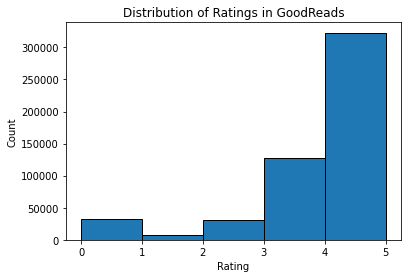

In [41]:
# === Distribution of ratings of rated books === #
# i.e. without the books with a rating of 0
plt.hist(read['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in GoodReads')
plt.show()

Here's what a subset of it looks like as a crosstabulation, which makes it into a dense matrix.

In [42]:
# === Create crosstab of users-books === #
g = read.groupby("user_id")["rating"].count()
topUsers = g.sort_values(ascending=False)[:15]

g = read.groupby("book_id")["rating"].count()
topMovies = g.sort_values(ascending=False)[:15]

top_r = read.join(topUsers, rsuffix="_r", how="inner", on="user_id")
top_r = top_r.join(topMovies, rsuffix="_r", how="inner", on="book_id")

pd.crosstab(top_r["user_id"], top_r["book_id"], top_r["rating"], aggfunc=np.sum)

book_id,16299,18342,19486412,22557272,2429135,5060378,5358,5886881,6411961,6853,6892870,8442457,960,968,976
user_id,,,,,,,,,,,,,,,
037c382333b7084ccee4cdec7401de90,4.0,NaN,5.0,5.0,NaN,5.0,5.0,NaN,5.0,4.0,5.0,NaN,5.0,5.0,NaN
054716762769ce2431afa2982bd2727b,5.0,NaN,NaN,2.0,4.0,3.0,NaN,NaN,NaN,4.0,3.0,3.0,2.0,NaN,NaN
10b78deeb01722248f3e3fc08ef813a6,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4708d71de2f8afe1064a703312b022b5,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,3.0,3.0,NaN
47a73c38a3acadbd58ad7f55f6e0cde9,5.0,NaN,NaN,NaN,5.0,5.0,4.0,NaN,5.0,5.0,NaN,NaN,5.0,4.0,5.0
4d801d302874e6e7313355949d4c18c3,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN,3.0,1.0,1.0,NaN
56be2435e7d93b1648618a42c7847906,NaN,5.0,NaN,NaN,5.0,4.0,5.0,NaN,5.0,NaN,5.0,NaN,5.0,4.0,4.0
75fa3b8ce55550b5241d8add69999d09,5.0,NaN,NaN,4.0,4.0,NaN,4.0,NaN,NaN,3.0,NaN,NaN,NaN,3.0,NaN
8e7e5b546a63cb9add8431ee6914cf59,5.0,NaN,5.0,NaN,NaN,3.0,NaN,5.0,NaN,3.0,2.0,5.0,1.0,NaN,NaN


---
---

## Modeling

For this model, I'll be using the FastAI collaborative filtering algorithm(s).

Resources:

* [fastai.collab](https://docs.fast.ai/collab.html)
* [movielens recommender example](https://github.com/microsoft/recommenders/blob/master/notebooks/00_quick_start/fastai_movielens.ipynb)

In [ ]:
# === First, train on rated books only === #
rating_range = [1, 5]

# Create databunch
data = CollabDataBunch.from_df(
    inters_rated,
    user_name="user_id",
    item_name="book_id",
    rating_name="rating",
    valid_pct=0.2,
    seed=92
)

# === Instantiate learner === #
learn = collab_learner(data, n_factors=50, y_range=rating_range)
learn.model

In [ ]:
data.show_batch()

user_id,book_id,target
82,51,4.0
1761,8945,2.0
779,13588,3.0
1627,22778,5.0
1720,3098,4.0


In [ ]:
# === Train! === #
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.123155,1.084469,00:10
1,0.634403,0.753151,00:12
2,0.298588,0.739403,00:12
3,0.128401,0.741949,00:11
4,0.073346,0.742687,00:10


In [ ]:
# === Export trained model === #
learn.export("/content/drive/My Drive/workshop/buildbox/likewise/assets/models/01_likewise.pkl")

---

## Generate Recommendations

In [ ]:
# === Import the model from file === #
learner = load_learner(
    path="/content/drive/My Drive/workshop/buildbox/likewise/assets/models/",
    file="01_likewise.pkl",
)

In [ ]:
# === Get all users and items that the model knows === #
total_users, total_items = learner.data.train_ds.x.classes.values()
total_items = total_items[1:]
total_users = total_users[1:]

print(total_users.shape, total_items.shape)

(1613,) (15925,)


In [ ]:
# Get all users from the test set and remove any users
# that were know in the training set

test_users = test_df[USER].unique()
test_users = np.intersect1d(test_users, total_users)

In [ ]:
from itertools import product

users_items = product(np.array(total_users), np.array(total_items))
users_items = pd.DataFrame(users_items, columns=["user_id", "book_id"])

In [ ]:
users_items

,user_id,book_id
0,1,1
1,1,10
2,1,100
3,1,1000
4,1,10001
...,...,...
25687020,999,9990
25687021,999,9992
25687022,999,9993
25687023,999,9996


My search for how to generate recommendations led me to looking at the [`score` function](https://github.com/microsoft/recommenders/blob/master/reco_utils/recommender/fastai/fastai_utils.py) in the reco_utils module, which is used in one of the notebooks I'm referencing [here](https://github.com/microsoft/recommenders/blob/master/notebooks/00_quick_start/fastai_movielens.ipynb).

I copied the `score` function into the cell below to try and use some of it to write my own recommendation function.

In [ ]:
def score(
    learner,
    test_df,
    user_col=cc.DEFAULT_USER_COL,
    item_col=cc.DEFAULT_ITEM_COL,
    prediction_col=cc.DEFAULT_PREDICTION_COL,
    top_k=None,
):
    """Score all users+items provided and reduce to top_k items per user if top_k>0
    
    Args:
        learner (obj): Model.
        test_df (pd.DataFrame): Test dataframe.
        user_col (str): User column name.
        item_col (str): Item column name.
        prediction_col (str): Prediction column name.
        top_k (int): Number of top items to recommend.
    Returns:
        pd.DataFrame: Result of recommendation 
    """
    # replace values not known to the model with NaN
    total_users, total_items = learner.data.train_ds.x.classes.values()
    test_df.loc[~test_df[user_col].isin(total_users), user_col] = np.nan
    test_df.loc[~test_df[item_col].isin(total_items), item_col] = np.nan

    # map ids to embedding ids
    u = learner.get_idx(test_df[user_col], is_item=False)
    m = learner.get_idx(test_df[item_col], is_item=True)

    # score the pytorch model
    pred = learner.model.forward(u, m)
    scores = pd.DataFrame(
        {user_col: test_df[user_col], item_col: test_df[item_col], prediction_col: pred}
    )
    scores = scores.sort_values([user_col, prediction_col], ascending=[True, False])
    if top_k is not None:
        top_scores = scores.groupby(user_col).head(top_k).reset_index(drop=True)
    else:
        top_scores = scores
    return top_scores